In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import torchvision

# COCO classes
CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

coco_idx_to_label = {idx: label for idx, label in enumerate(CLASSES)}

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

import matplotlib.pyplot as plt

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        output_tensor = []
        for t, m, s in zip(tensor, self.mean, self.std):
            output_tensor.append(t.mul(s).add(m))
            # t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return torch.stack(output_tensor, dim=0)

unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(img, labels, boxes, mask=None):
    h, w = img.shape[1:]
    if mask != None:
        # width
        if torch.where(mask[0])[0].shape[0] > 0:
            mask_w = torch.where(mask[0])[0][0]
            w = min(w, mask_w)
        if torch.where(mask[:, 0])[0].shape[0]:
            mask_h = torch.where(mask[:, 0])[0][0]
            h = min(h, mask_h)
            
    boxes = rescale_bboxes(boxes, (w, h))
    plt.figure(figsize=(16,10))
    unimage = unnorm(img)
    #image = (unimage*256).to(torch.uint8)
    image = unimage
    pil_img = torchvision.transforms.functional.to_pil_image(image)
    plt.imshow(pil_img)
    
    ax = plt.gca()
    colors = COLORS * 100
    for label, (xmin, ymin, xmax, ymax), c in zip(labels, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{CLASSES[label]}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [8]:
from argparse import Namespace
args = Namespace(lr=0.0002, lr_backbone_names=['backbone.0'], lr_backbone=2e-05, lr_linear_proj_names=['reference_points', 'sampling_offsets'], lr_linear_proj_mult=0.1, batch_size=1, weight_decay=0.0001, epochs=200, lr_drop=100, save_period=50, lr_drop_epochs=None, clip_max_norm=0.1, meta_arch='motr', sgd=False, with_box_refine=True, two_stage=False, accurate_ratio=False, frozen_weights=None, num_anchors=1, backbone='resnet50', enable_fpn=False, dilation=False, position_embedding='sine', position_embedding_scale=6.283185307179586,num_feature_levels=4, enc_layers=6, dec_layers=6, dim_feedforward=1024, hidden_dim=256, dropout=0.0, nheads=8, num_queries=300, dec_n_points=4, enc_n_points=4, decoder_cross_self=False, sigmoid_attn=False, crop=False, cj=False, extra_track_attn=True, loss_normalizer=False, max_size=1333, val_width=800, filter_ignore=False, masks=False, aux_loss=True, mix_match=False, set_cost_class=2, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, cls_loss_coef=2, bbox_loss_coef=5, giou_loss_coef=2, focal_alpha=0.25, dataset_file='e2e_joint', gt_file_train=None, gt_file_val=None, coco_path='/data/workspace/detectron2/datasets/coco/', coco_panoptic_path=None, remove_difficult=False, output_dir='exps/e2e_motr_r50_joint', device='cuda', seed=42, resume='', start_epoch=0, eval=False, vis=False, num_workers=2, pretrained='r50_deformable_detr_plus_iterative_bbox_refinement-checkpoint.pth', cache_mode=False, mot_path='data', input_video='figs/demo.mp4', data_txt_path_train='./datasets/data_path/joint.train', data_txt_path_val='./datasets/data_path/mot17.train', img_path='data/valid/JPEGImages/', query_interaction_layer='QIM', sample_mode='random_interval', sample_interval=10, random_drop=0.1, fp_ratio=0.3, merger_dropout=0.0, update_query_pos=True, sampler_steps=[50, 90, 150], sampler_lengths=[2, 3, 4, 5], exp_name='submit', memory_bank_score_thresh=0.0, memory_bank_len=4, memory_bank_type=None, memory_bank_with_self_attn=False, use_checkpoint=True, rank=0, world_size=1, gpu=0, dist_url='env://', distributed=True, dist_backend='nccl')

In [4]:
import argparse
import datetime
import json
import random
import time
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader
import datasets

from util.motdet_eval import motdet_evaluate, detmotdet_evaluate
from util.tool import load_model
import util.misc as utils
import datasets.samplers as samplers
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch, train_one_epoch_mot
from models import build_model


In [5]:
device = torch.device(args.device)

# fix the seed for reproducibility
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [9]:
dataset_train = build_dataset(image_set='train', args=args)

register 1-th video: data/crowdhuman/labels_with_ids/val 
register 2-th video: data/MOT17/labels_with_ids/train/MOT17-02-SDP/img1 
register 3-th video: data/MOT17/labels_with_ids/train/MOT17-04-SDP/img1 
register 4-th video: data/MOT17/labels_with_ids/train/MOT17-05-SDP/img1 
register 5-th video: data/MOT17/labels_with_ids/train/MOT17-09-SDP/img1 
register 6-th video: data/MOT17/labels_with_ids/train/MOT17-10-SDP/img1 
register 7-th video: data/MOT17/labels_with_ids/train/MOT17-11-SDP/img1 
register 8-th video: data/MOT17/labels_with_ids/train/MOT17-13-SDP/img1 
sampler_steps=[50, 90, 150] lenghts=[2, 3, 4, 5]


In [10]:
example = dataset_train[0]
example

{'imgs': [tensor([[[ 0.9817,  0.2796,  0.3309,  ...,  0.5536,  0.5878,  0.6049],
           [ 0.7077,  0.1597,  0.5364,  ...,  0.5707,  0.5878,  0.6049],
           [ 0.2111,  0.3309,  0.8789,  ...,  0.5878,  0.6049,  0.6049],
           ...,
           [-0.9705, -0.9363, -0.9363,  ...,  0.2624,  0.2453,  0.2453],
           [-0.9192, -0.9192, -0.9192,  ...,  0.2282,  0.2453,  0.2453],
           [-0.9020, -0.9192, -0.9020,  ...,  0.2111,  0.2282,  0.2282]],
  
          [[ 1.7808,  1.0105,  1.0280,  ...,  1.5357,  1.5707,  1.5882],
           [ 1.4832,  0.8880,  1.2381,  ...,  1.5532,  1.5707,  1.5882],
           [ 0.9405,  1.0630,  1.5707,  ...,  1.5707,  1.5882,  1.5882],
           ...,
           [-2.0182, -2.0007, -2.0007,  ..., -1.6506, -1.6681, -1.6681],
           [-2.0357, -2.0357, -2.0357,  ..., -1.6856, -1.6681, -1.6681],
           [-2.0357, -2.0357, -2.0182,  ..., -1.7031, -1.6856, -1.6856]],
  
          [[ 2.1520,  1.4897,  1.5768,  ...,  2.5877,  2.6226,  2.6400],
   

In [11]:
example["gt_instances"][0].labels

tensor([0, 0, 0, 0, 0, 0])

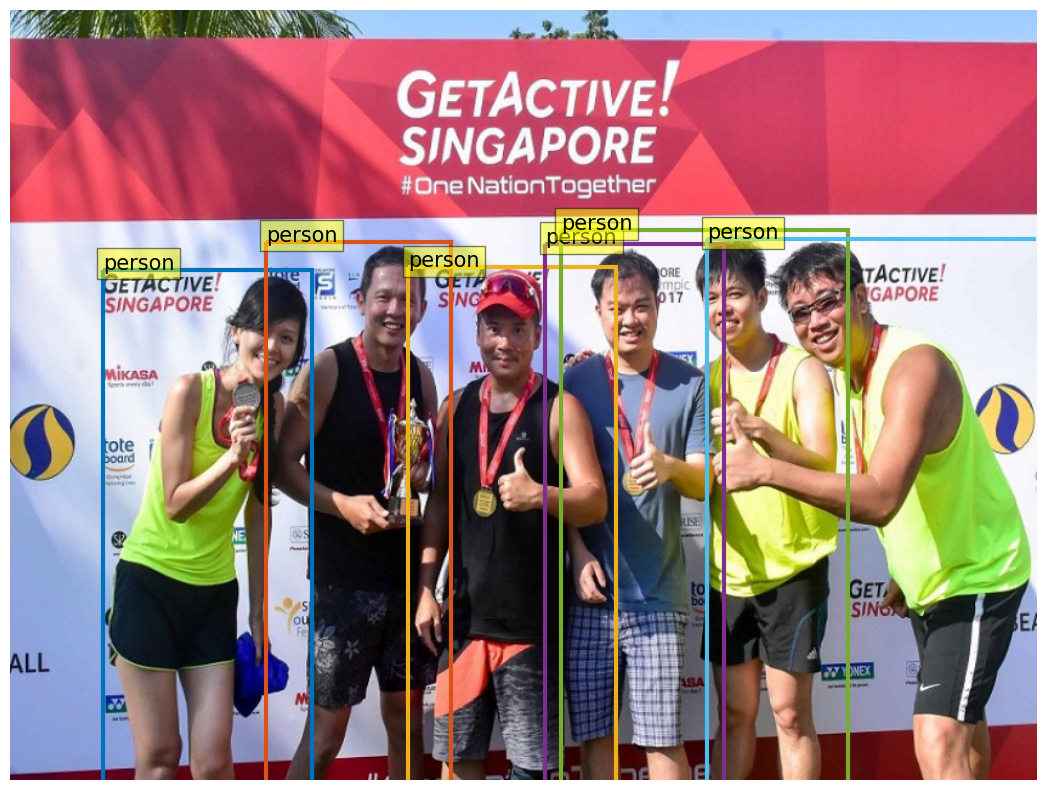

In [12]:
plot_results(example["imgs"][0], example["gt_instances"][0].labels, example["gt_instances"][0].boxes)

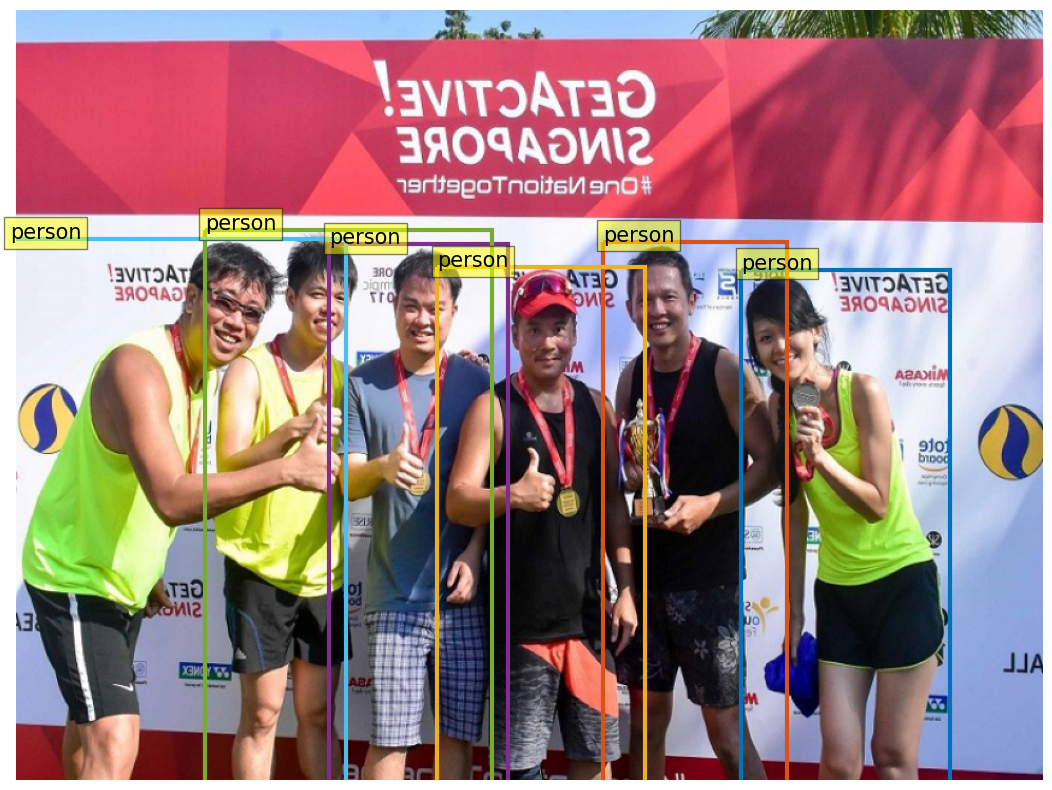

In [13]:
example = dataset_train[0]
plot_results(example["imgs"][0], example["gt_instances"][0].labels, example["gt_instances"][0].boxes)

In [14]:
sampler_train = torch.utils.data.RandomSampler(dataset_train)
batch_sampler_train = torch.utils.data.BatchSampler(
        sampler_train, args.batch_size, drop_last=True)
if args.dataset_file in ['e2e_mot', 'e2e_dance', 'mot', 'ori_mot', 'e2e_static_mot', 'e2e_joint']:
    collate_fn = utils.mot_collate_fn
else:
    collate_fn = utils.collate_fn
data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                collate_fn=collate_fn, num_workers=args.num_workers,
                                pin_memory=True)

In [15]:
for sample in data_loader_train:
    break
sample

{'imgs': [tensor([[[ 1.2557,  1.2557,  1.2728,  ...,  0.6906,  0.0741, -0.2684],
           [ 1.2557,  1.2557,  1.2557,  ...,  0.7762,  0.4508,  0.2796],
           [ 1.2557,  1.2557,  1.2385,  ...,  0.9474,  1.1187,  1.2214],
           ...,
           [-0.4054, -0.4739, -0.6452,  ...,  0.5878,  0.5536,  0.5364],
           [-0.5424, -0.6109, -0.7479,  ...,  0.6049,  0.5707,  0.5536],
           [-0.6281, -0.6965, -0.7993,  ...,  0.6221,  0.5878,  0.5536]],
  
          [[ 1.5882,  1.5882,  1.6057,  ...,  0.9930,  0.3803,  0.0476],
           [ 1.5882,  1.5882,  1.5882,  ...,  1.0805,  0.7479,  0.5728],
           [ 1.5882,  1.5882,  1.5707,  ...,  1.2206,  1.4132,  1.5182],
           ...,
           [ 0.1352,  0.1527,  0.1702,  ...,  0.6779,  0.6429,  0.6254],
           [ 0.0476,  0.0476,  0.0301,  ...,  0.6954,  0.6604,  0.6254],
           [-0.0049, -0.0224, -0.0574,  ...,  0.6954,  0.6604,  0.6254]],
  
          [[ 2.0125,  2.0125,  2.0300,  ...,  1.5942,  1.0888,  0.7925],
   

In [16]:
from datasets.data_prefetcher import data_dict_to_cuda
sample = data_dict_to_cuda(sample, device)

In [17]:
model, criterion, postprocessors = build_model(args)
model.to(device)

/home/ubuntu/miniconda3/envs/motr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniconda3/envs/motr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training with Extra Self Attention in Every Decoder.
Training with Self-Cross Attention.


MOTR(
  (track_embed): QueryInteractionModule(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=1024, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (linear2): Linear(in_features=1024, out_features=256, bias=True)
    (linear_pos1): Linear(in_features=256, out_features=1024, bias=True)
    (linear_pos2): Linear(in_features=1024, out_features=256, bias=True)
    (dropout_pos1): Dropout(p=0.0, inplace=False)
    (dropout_pos2): Dropout(p=0.0, inplace=False)
    (norm_pos): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (linear_feat1): Linear(in_features=256, out_features=1024, bias=True)
    (linear_feat2): Linear(in_features=1024, out_features=256, bias=True)
    (dropout_feat1): Dropout(p=0.0, inplace=False)
    (dropout_feat2): Dropout(p=0.0, inplace=False)
    (norm_feat): LayerNorm((256,), eps=1e-05, elementwise_affine=

In [18]:
preds = model(sample)
preds

/home/ubuntu/miniconda3/envs/motr/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'pred_logits': [tensor([[[-4.9981],
           [-5.1234],
           [-5.2848],
           [-5.0879],
           [-5.2047],
           [-5.2149],
           [-4.8720],
           [-4.7949],
           [-5.0334],
           [-5.2259],
           [-4.9137],
           [-5.2204],
           [-4.9604],
           [-4.9879],
           [-5.1099],
           [-4.9588],
           [-5.1828],
           [-5.1157],
           [-5.4647],
           [-4.9802],
           [-5.3123],
           [-5.1861],
           [-5.0545],
           [-4.9378],
           [-5.1627],
           [-5.1040],
           [-5.0935],
           [-5.0634],
           [-5.2019],
           [-5.0562],
           [-4.8043],
           [-5.0922],
           [-5.1885],
           [-5.0041],
           [-5.1510],
           [-5.1824],
           [-5.3065],
           [-5.1568],
           [-5.0420],
           [-5.1667],
           [-5.1925],
           [-5.2079],
           [-5.1648],
           [-5.2290],
           [-5.13

In [19]:
loss = criterion(preds, sample)
loss

{'frame_0_loss_ce': tensor(0.7198, device='cuda:0', grad_fn=<DivBackward0>),
 'frame_0_loss_bbox': tensor(0.1600, device='cuda:0', grad_fn=<DivBackward0>),
 'frame_0_loss_giou': tensor(0.4891, device='cuda:0', grad_fn=<DivBackward0>),
 'frame_0_aux0_loss_ce': tensor(0.6447, device='cuda:0', grad_fn=<DivBackward0>),
 'frame_0_aux0_loss_bbox': tensor(0.1611, device='cuda:0', grad_fn=<DivBackward0>),
 'frame_0_aux0_loss_giou': tensor(0.4891, device='cuda:0', grad_fn=<DivBackward0>),
 'frame_0_aux1_loss_ce': tensor(0.6197, device='cuda:0', grad_fn=<DivBackward0>),
 'frame_0_aux1_loss_bbox': tensor(0.1620, device='cuda:0', grad_fn=<DivBackward0>),
 'frame_0_aux1_loss_giou': tensor(0.4908, device='cuda:0', grad_fn=<DivBackward0>),
 'frame_0_aux2_loss_ce': tensor(0.5789, device='cuda:0', grad_fn=<DivBackward0>),
 'frame_0_aux2_loss_bbox': tensor(0.1591, device='cuda:0', grad_fn=<DivBackward0>),
 'frame_0_aux2_loss_giou': tensor(0.4910, device='cuda:0', grad_fn=<DivBackward0>),
 'frame_0_aux3_

In [20]:
len(example["imgs"])

2

In [36]:
dataset_train.set_epoch(150)
example = dataset_train[0]
len(example["imgs"])

set epoch: epoch 150 period_idx=3


5

In [31]:
i

5

In [34]:
example["imgs"][0].shape, example["imgs"][1].shape

(torch.Size([3, 928, 1237]), torch.Size([3, 928, 1237]))

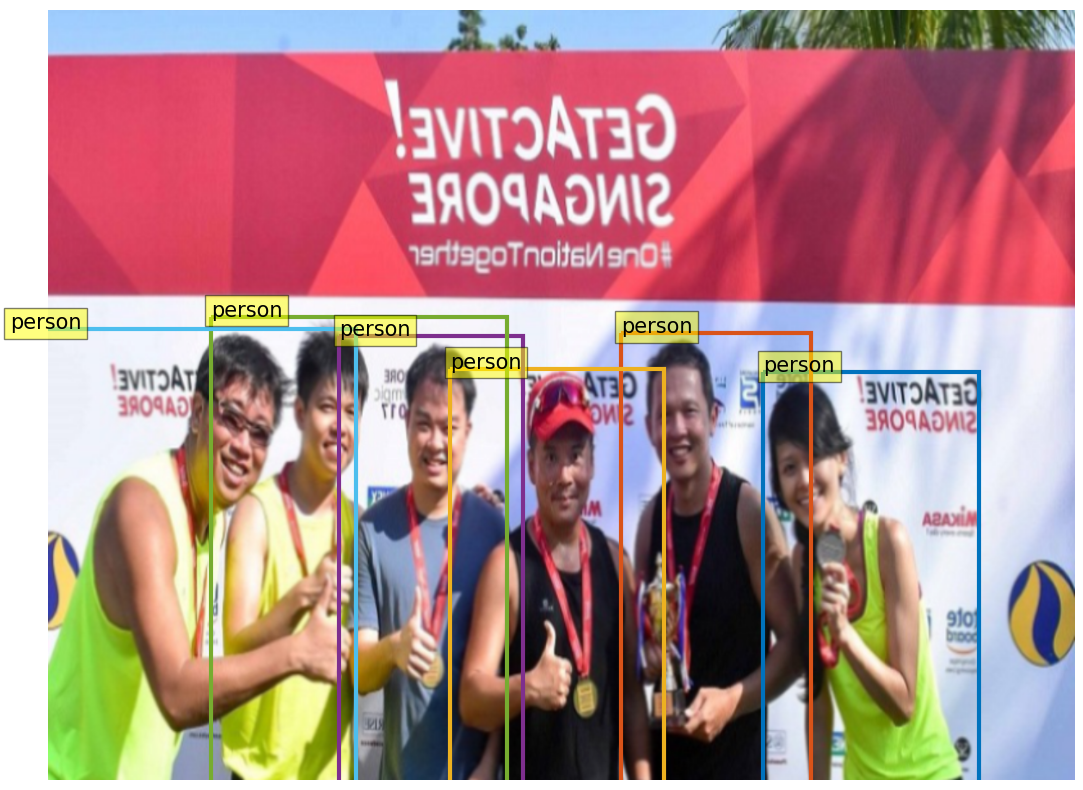

In [29]:

plot_results(example["imgs"][i], example["gt_instances"][i].labels, example["gt_instances"][i].boxes)
i += 1